# import

In [690]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder

In [691]:
df_train = pd.read_csv('train.csv')

In [692]:
df_test = pd.read_csv('test.csv')

In [693]:
sample_submission = pd.read_csv('sample_submission.csv')

In [694]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [695]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


In [696]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# EDA 

проверим наличие пропусков в данных

In [697]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

### 1. education 

пропуски имеются только в столбце education. Заполним их новым значением.

In [698]:
data.education.unique()

array(['GRD', 'SCH', 'UGR', 'PGR', nan, 'ACD'], dtype=object)

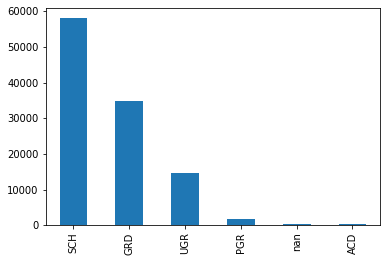

In [699]:
data.education.value_counts(dropna=False).plot.bar()


In [700]:
data.education.fillna(value='WAE', inplace=True)

### 2. app_date

In [701]:
data.app_date.unique()

array(['22MAR2014', '24JAN2014', '23MAR2014', '03FEB2014', '04FEB2014',
       '17APR2014', '02FEB2014', '28MAR2014', '23JAN2014', '24APR2014',
       '25FEB2014', '15JAN2014', '13APR2014', '12MAR2014', '17MAR2014',
       '01FEB2014', '15FEB2014', '01APR2014', '20FEB2014', '20APR2014',
       '27JAN2014', '24FEB2014', '18JAN2014', '16JAN2014', '13FEB2014',
       '02APR2014', '07MAR2014', '08APR2014', '21FEB2014', '16MAR2014',
       '08JAN2014', '24MAR2014', '19MAR2014', '19JAN2014', '18APR2014',
       '05APR2014', '25MAR2014', '06MAR2014', '29APR2014', '28APR2014',
       '22JAN2014', '27MAR2014', '31JAN2014', '11JAN2014', '22FEB2014',
       '05FEB2014', '07APR2014', '14MAR2014', '06APR2014', '02MAR2014',
       '06JAN2014', '05MAR2014', '10MAR2014', '22APR2014', '26FEB2014',
       '16FEB2014', '01MAR2014', '04JAN2014', '30JAN2014', '09FEB2014',
       '11FEB2014', '04MAR2014', '29JAN2014', '04APR2014', '25APR2014',
       '19FEB2014', '14FEB2014', '26MAR2014', '13JAN2014', '18MA

дата подачи заявки - содержит дату. Можно преобразовать в pd.Datetime

In [702]:
data.app_date = pd.to_datetime(data.app_date)

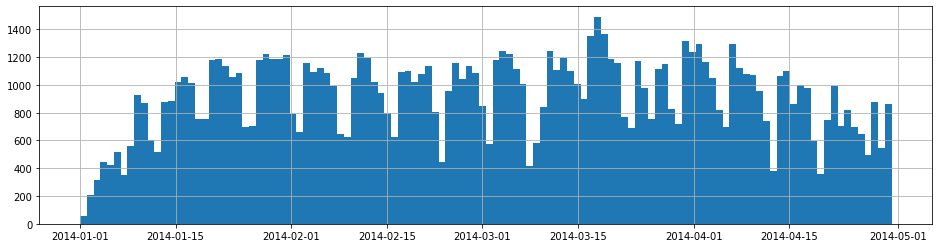

In [703]:
plt.figure(figsize=(16,4))
data.app_date.hist(bins= 120)

In [704]:
# и преобразуем в категориальный признак - день недели
data.app_date = data.app_date.dt.dayofweek

### 3. sex
бинарный признак

In [705]:
data.sex.unique()

array(['M', 'F'], dtype=object)

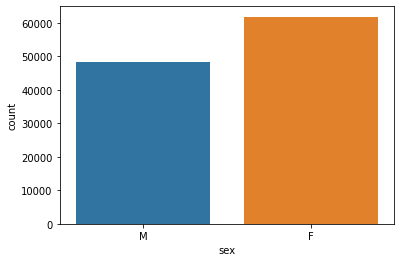

In [706]:
sns.countplot(x=data.sex)

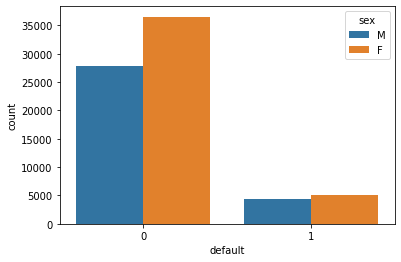

In [707]:
sns.countplot(x='default', hue='sex', data = data[data['sample'] == 1])

женщин среди заемщиков немного больше. а так же немного больше случаев дефолта

### 4. age

In [708]:
data.age.unique()

array([29, 39, 50, 56, 38, 55, 30, 41, 34, 28, 32, 37, 43, 27, 46, 52, 49,
       53, 36, 61, 25, 24, 42, 51, 33, 45, 44, 47, 23, 22, 48, 31, 40, 57,
       65, 59, 35, 21, 64, 26, 67, 63, 66, 68, 60, 54, 58, 69, 62, 70, 71,
       72])

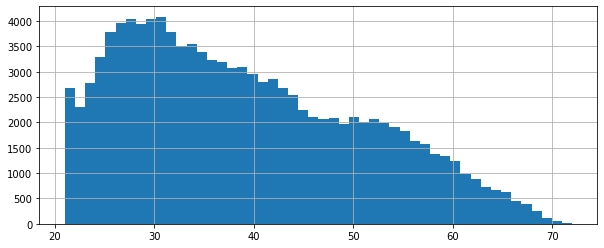

In [709]:
plt.figure(figsize= (10,4))
data.age.hist(bins=50)

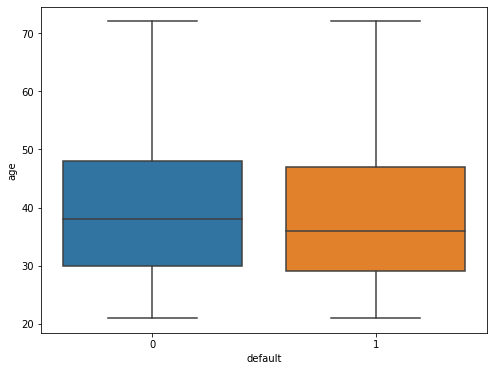

In [710]:
plt.figure(figsize=(8,6))
sns.boxplot(y = data['age'], x = data[data['sample'] == 1]['default'])

значений возраста <20 лет и превышающие, разумную продолжительность жизни не обнаружено.
дефолтные клиенты младше

### 5. car

In [711]:
data.car.unique()

array(['Y', 'N'], dtype=object)

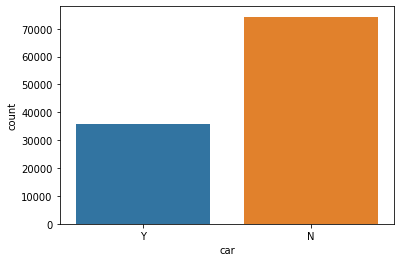

In [712]:
sns.countplot(x=data.car)

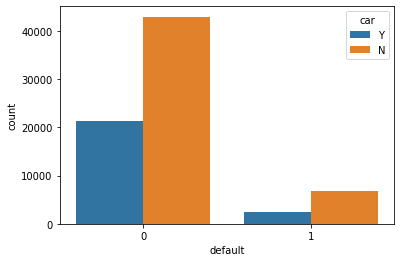

In [713]:
sns.countplot(x='default', hue='car', data = data[data['sample'] == 1])

случаев дефолта явно больше среди людей. не владеющих автомобилем

### 6. car_type

In [714]:
data.car_type.unique()

array(['Y', 'N'], dtype=object)

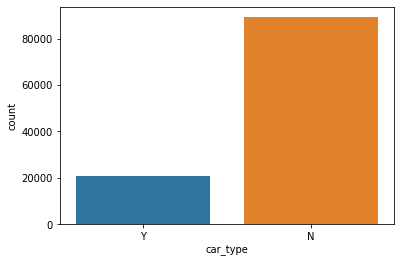

In [715]:
sns.countplot(x=data.car_type)

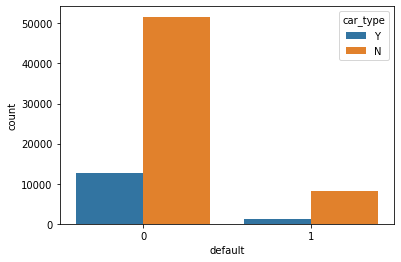

In [716]:
sns.countplot(x='default', hue='car_type', data = data[data['sample'] == 1])

так же владельцы иномарок - имеют меньший риск дефолта

### 7. decline_app_cnt

In [717]:
data.decline_app_cnt.unique()

array([ 0,  5,  3,  1,  2,  6,  4,  8, 10,  7, 12,  9, 14, 11, 16, 21, 13,
       30, 20, 19, 22, 33, 15, 24])

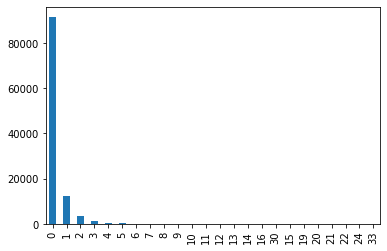

In [718]:
data.decline_app_cnt.value_counts().plot.bar()

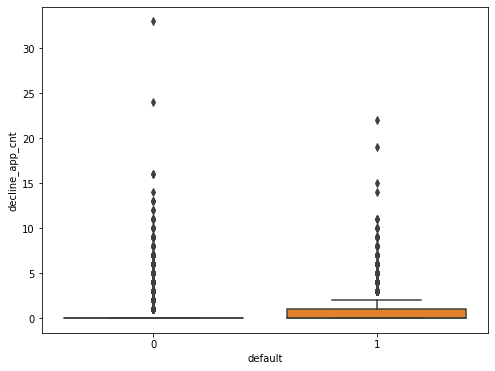

In [719]:
plt.figure(figsize=(8,6))
sns.boxplot(y = data[data['sample'] == 1]['decline_app_cnt'], x = data[data['sample'] == 1]['default'])

у дефолтных клиентов - больше отклоненных заявок

### 8. good_work

In [720]:
data.good_work.unique()

array([0, 1])

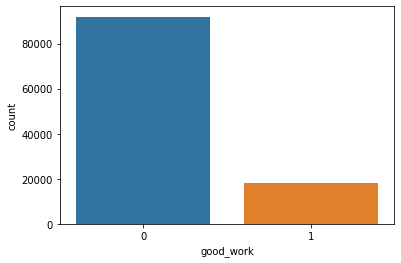

In [721]:
sns.countplot(x=data.good_work)

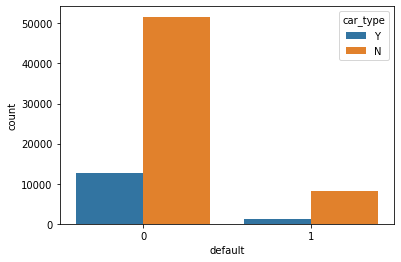

In [722]:
sns.countplot(x='default', hue='car_type', data = data[data['sample'] == 1])

бинарный признак. имеется отчетливая вероятность дефолта у людей без хорощей работы

### 9. score_bki

In [723]:
data.score_bki.nunique()

102618

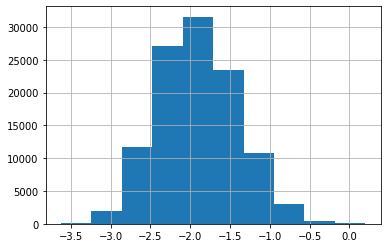

In [724]:
data.score_bki.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


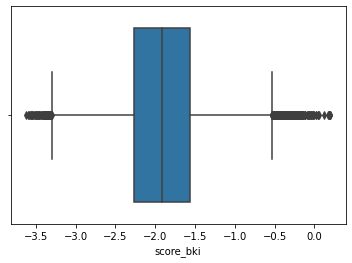

In [725]:
sns.boxplot(data.score_bki)

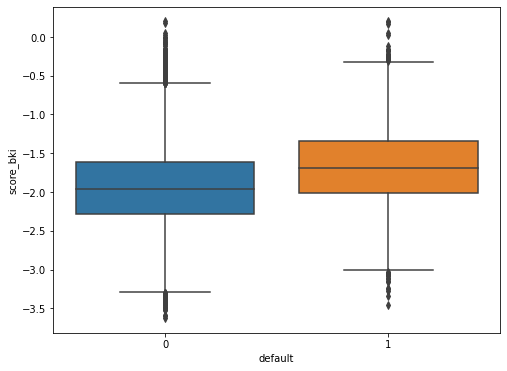

In [726]:
plt.figure(figsize=(8,6))
sns.boxplot(y = data[data['sample'] == 1]['score_bki'], x = data[data['sample'] == 1]['default'])

### 10. bki_request_cnt

In [727]:
data.bki_request_cnt.unique()

array([ 3,  2,  1,  0,  7,  5,  4,  6,  9,  8, 12, 10, 17, 13, 11, 14, 15,
       19, 27, 18, 16, 29, 21, 20, 47, 22, 23, 25, 33, 24, 32, 40, 26, 28,
       34, 36, 53, 45, 41, 46])

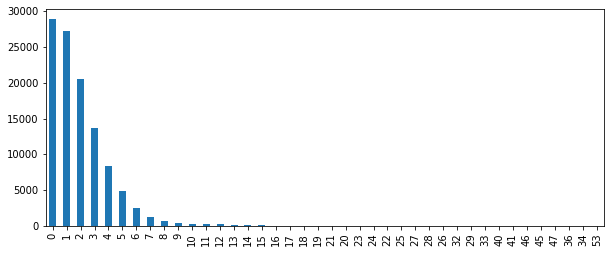

In [728]:
plt.figure(figsize=(10, 4))
data.bki_request_cnt.value_counts().plot.bar()

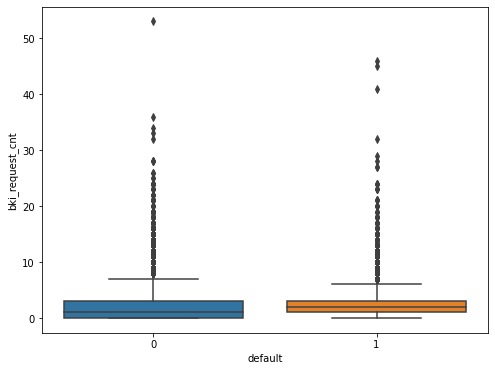

In [729]:
plt.figure(figsize=(8,6))
sns.boxplot(y = data[data['sample'] == 1]['bki_request_cnt'], x = data[data['sample'] == 1]['default'])

Дефолтные клиенты в среднем имеют больше запросов в БКИ

### 11. region_rating

In [730]:
data.region_rating.unique()

array([50, 40, 80, 60, 70, 20, 30])

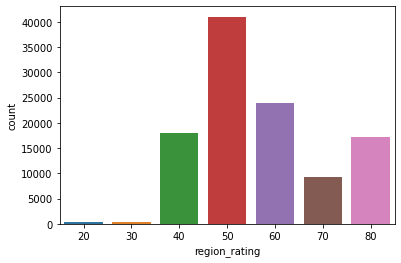

In [731]:
sns.countplot(x= data.region_rating)

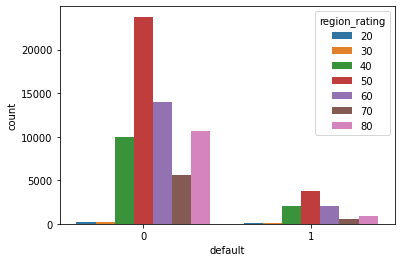

In [732]:
sns.countplot(x='default', hue='region_rating', data = data[data['sample'] == 1])

### 12. home_address

In [733]:
data.home_address.unique()

array([1, 2, 3])

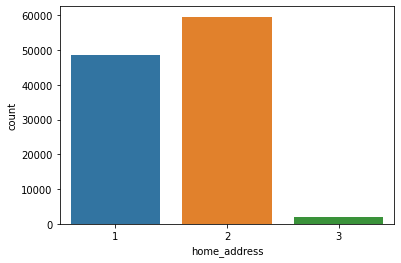

In [734]:
sns.countplot(x= data.home_address)

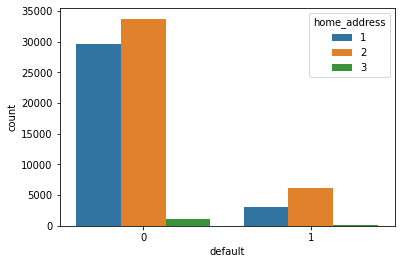

In [735]:
sns.countplot(x='default', hue='home_address', data = data[data['sample'] == 1])

### 13. work_address

In [736]:
data.work_address.unique()

array([2, 3, 1])

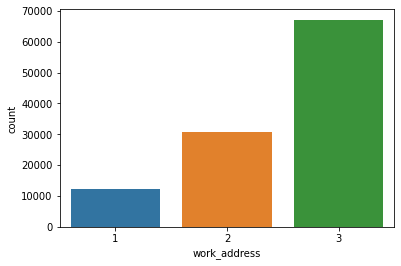

In [737]:
sns.countplot(x=data.work_address)

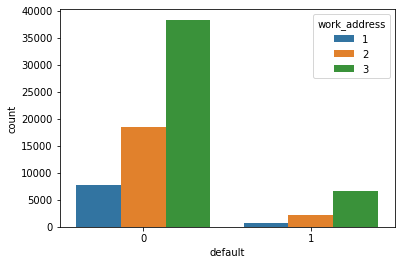

In [738]:
sns.countplot(x='default', hue= 'work_address', data=data[data['sample'] == 1])

### 14. income

In [739]:
data.income.nunique()

1207

In [740]:
data.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

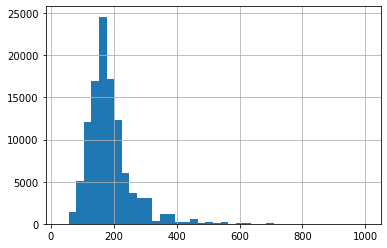

In [741]:
np.sqrt(data.income).hist(bins=40)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


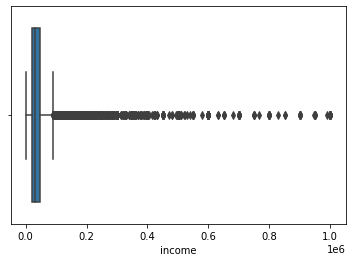

In [742]:
sns.boxplot(data.income)

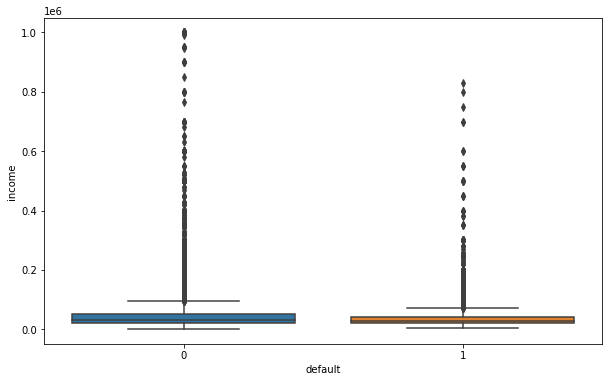

In [743]:
plt.figure(figsize=(10,6))
sns.boxplot(y = data[data['sample'] == 1]['income'], x = data[data['sample'] == 1]['default'])

Дефолтные клиенты в среднем имеют более низкий доход

### 15. sna

In [744]:
data.sna.unique()

array([1, 4, 2, 3])

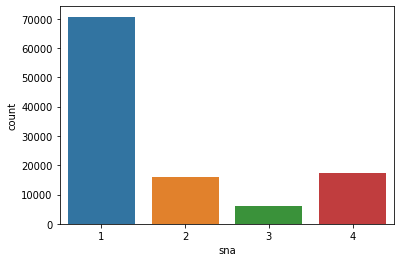

In [745]:
sns.countplot(x=data.sna)

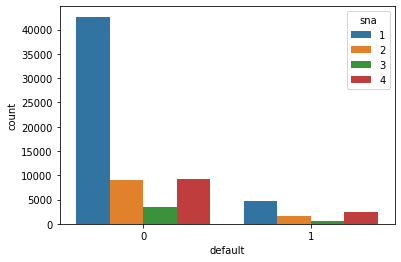

In [746]:
sns.countplot(x='default', hue= 'sna', data=data[data['sample'] == 1])

### 16. first_time

In [747]:
data.first_time.unique()

array([4, 3, 1, 2])

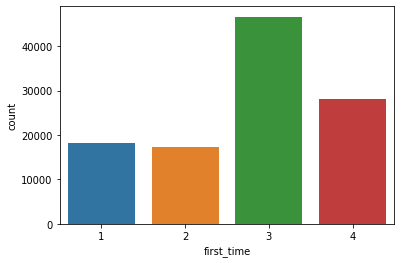

In [748]:
sns.countplot(x=data.first_time)

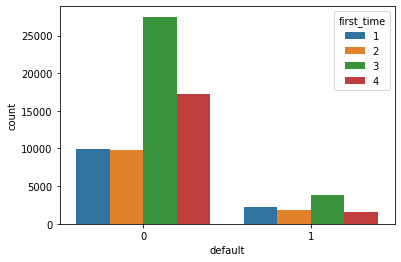

In [749]:
sns.countplot(x='default', hue= 'first_time', data=data[data['sample'] == 1])

### 17. foreign_passport

In [750]:
data.foreign_passport.unique()

array(['N', 'Y'], dtype=object)

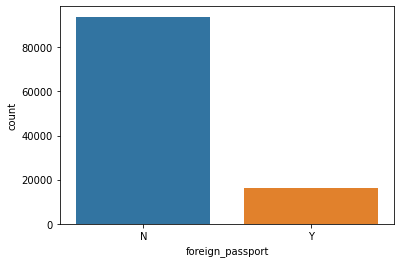

In [751]:
sns.countplot(x=data.foreign_passport)

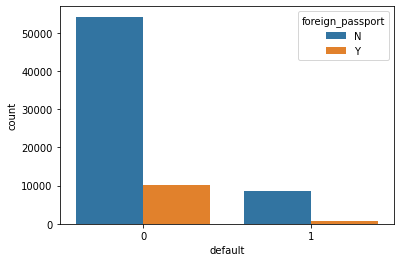

In [752]:
sns.countplot(x='default', hue= 'foreign_passport', data=data[data['sample'] == 1])

обладатели загран паспорта так же имеют меньшую вероятность дефолта

### 18. default

In [753]:
data[data['sample'] == 1].default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

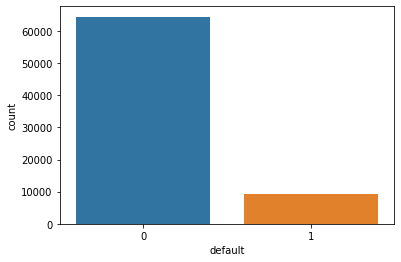

In [754]:
sns.countplot(x=data[data['sample'] == 1].default)

In [755]:
# для удобства обработки сгрупируем признаки по типу переменных

#  бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#  категориальные переменные
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating', 'app_date']

#  числовые переменные
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']


### Оценка корреляций

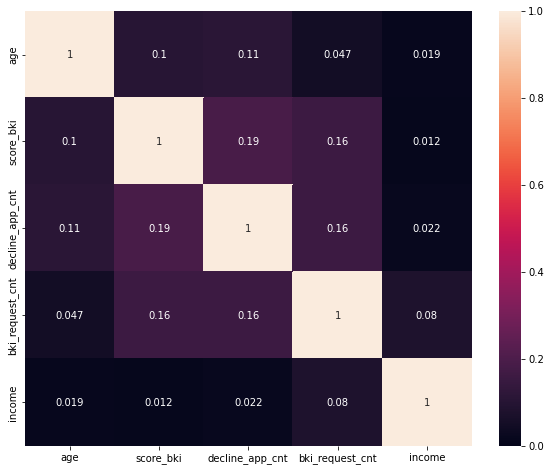

In [756]:
plt.figure(figsize=(10,8))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1,annot=True)

корреляция между числовыми признаками слабая

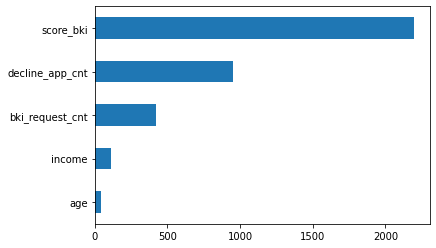

In [757]:
# Оценим значимость непрерывных переменных методом однофакторного дисперсионного анализа (ANOVA)
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ


Для этого преобразуем строковые переменные в числа.
Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif.

In [758]:
def education_to_num(L):
  if L == 'WAE':
    return 0
  elif L == 'GRD':
    return 1
  elif L == 'SCH':
    return 2
  elif L == 'UGR':
    return 3
  elif L == 'PGR':
    return 4
  else:
    return 5

In [759]:
data.education = data.education.apply(lambda L: education_to_num(L))

In [760]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

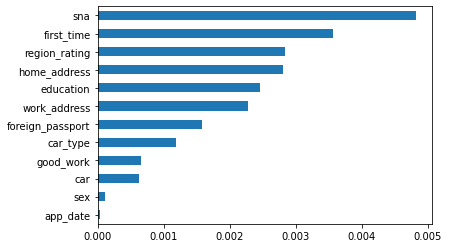

In [761]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [762]:
# так как значимость признака "app_date" не высока, исключим его из модели
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']

# Data Preprocessing

In [763]:
#  проведем  разделение на трейн, валидационную часть и тест 

train_validation = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [764]:
train, validation = train_test_split(train_validation, test_size=0.33, random_state=42)

### Преобразуем категориальные переменные с помощью  One-Hot Encoding

In [765]:
hot_encoder = OneHotEncoder(sparse = False)

In [766]:
X_cat_train = hot_encoder.fit_transform(train[cat_cols].values)
X_cat_valid = hot_encoder.transform(validation[cat_cols].values)
X_cat_test = hot_encoder.transform(test[cat_cols].values)

### Стандартизация числовых переменных

In [767]:
scaler = StandardScaler()
X_num_train = scaler.fit_transform(train[num_cols].values)
X_num_valid = scaler.transform(validation[num_cols].values)
X_num_test = scaler.transform(test[num_cols].values)

### Oбъединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [768]:
X_train = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y_train = train['default'].values

X_validation = np.hstack([X_num_valid, validation[bin_cols].values, X_cat_valid])
y_validation = validation['default'].values

X_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

# модель

In [769]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [770]:
model = LogisticRegression(max_iter=1000)

In [771]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [772]:
y_pred = model.predict(X_validation)
y_pred_proba = model.predict_proba(X_validation)

# Метрики

In [773]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
classification_report_ = classification_report(y_validation, y_pred)
print(classification_report_)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     21294
           1       0.40      0.02      0.04      3060

    accuracy                           0.87     24354
   macro avg       0.64      0.51      0.49     24354
weighted avg       0.82      0.87      0.82     24354



In [774]:
confusion_matrix(y_validation, y_pred).T

array([[21193,  2992],
       [  101,    68]])

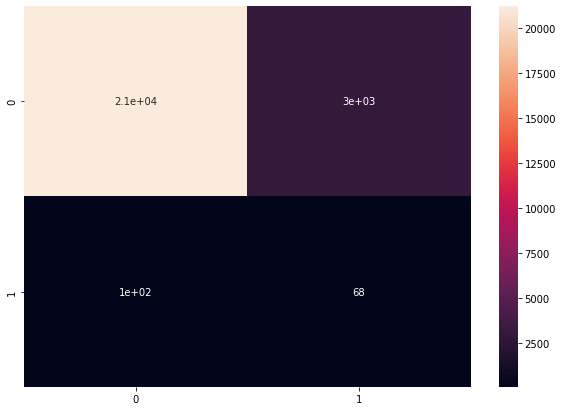

In [775]:

df_cm = pd.DataFrame(confusion_matrix(y_validation, y_pred).T, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True);

In [776]:
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

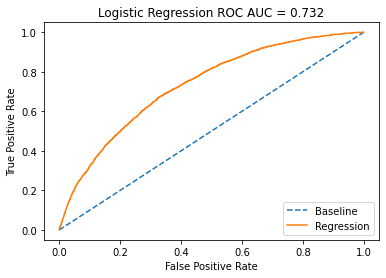

In [777]:
calc_and_plot_roc(y_validation, y_pred_proba[:,1])

## Произведем поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке param_grid.

In [778]:
from sklearn.model_selection import GridSearchCV

In [779]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['None', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['None', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['None'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['None', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 220.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1150, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_, y=y)
  Fil

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [780]:
model_1 = LogisticRegression(C= 1.0,
	class_weight= 'balanced',
	dual= False,
	fit_intercept= True,
	intercept_scaling= 1,
	l1_ratio= None,
	max_iter= 50,
	multi_class= 'ovr',
	n_jobs= None,
	# penalty= 'l2',
	penalty= 'l1',
	random_state= None,
	# solver= 'saga',
	solver= 'liblinear',
	tol= 0.001,
	verbose= 0,
	warm_start= False)

In [781]:
model_1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=50, multi_class='ovr',
                   penalty='l1', solver='liblinear', tol=0.001)

In [782]:
y_pred_1 = model_1.predict(X_validation)
y_pred_proba_1 = model_1.predict_proba(X_validation)

## оценим опять метрики на оптимизированной модели

In [783]:
# первоначальная модель
classification_report_ = classification_report(y_validation, y_pred)
print(classification_report_)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     21294
           1       0.40      0.02      0.04      3060

    accuracy                           0.87     24354
   macro avg       0.64      0.51      0.49     24354
weighted avg       0.82      0.87      0.82     24354



In [784]:
# улучшенная модель
classification_report_ = classification_report(y_validation, y_pred_1)
print(classification_report_)

              precision    recall  f1-score   support

           0       0.93      0.66      0.78     21294
           1       0.22      0.68      0.34      3060

    accuracy                           0.67     24354
   macro avg       0.58      0.67      0.56     24354
weighted avg       0.85      0.67      0.72     24354



In [785]:
confusion_matrix(y_validation, y_pred_1,).T

array([[14155,   989],
       [ 7139,  2071]])

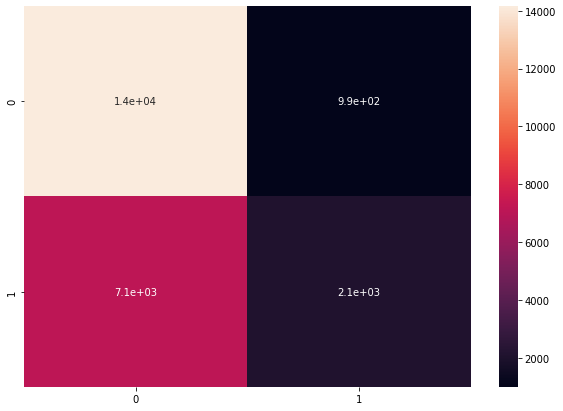

In [786]:

df_cm = pd.DataFrame(confusion_matrix(y_validation, y_pred_1,).T, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True);

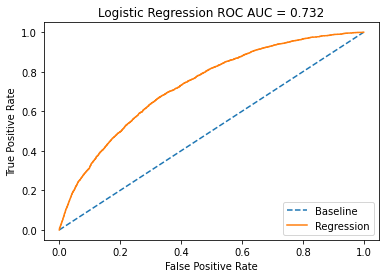

In [787]:
calc_and_plot_roc(y_validation, y_pred_proba_1[:,1])

# обучаем финальную модель на всех обучающи данных







In [788]:
X = np.vstack([X_train, X_validation])

In [789]:
X.shape

(73799, 37)

In [790]:
Y = np.hstack([y_train, y_validation])

In [791]:
Y.shape

(73799,)

In [792]:
model_2 = LogisticRegression(C= 1.0,
	class_weight= 'balanced',
	dual= False,
	fit_intercept= True,
	intercept_scaling= 1,
	l1_ratio= None,
	max_iter= 50,
	multi_class= 'ovr',
	n_jobs= None,
	# penalty= 'l2',
	penalty= 'l1',
	random_state= None,
	# solver= 'saga',
	solver= 'liblinear',
	tol= 0.001,
	verbose= 0,
	warm_start= False)

model_2.fit(X, Y)

y_pred_2 = model_2.predict(X_validation)
y_pred_proba_2 = model_2.predict_proba(X_validation)


# Submission

In [793]:
predict_submission = model_2.predict(X_test)

In [794]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [795]:
sample_submission.shape

(36349, 2)